In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
import scipy.stats as st
from pathlib import Path

np.random.seed(42)

data = load_diabetes(as_frame=True)
df = data.frame.copy()
df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [5]:
## 1) 95% CI for the mean (σ unknown → t CI)

In [3]:
def ci_for_mean_t(sample, alpha=0.05):
    n = len(sample)
    xbar = np.mean(sample)
    s = np.std(sample, ddof=1) #표본 표준편차를 계산하기 위해서 자유도를 n-1로 두어야 하기 때문에 ddof = 1
    se = s / np.sqrt(n)
    tcrit = st.t.ppf(1 - alpha/2, df=n-1)
    lo, hi = xbar - tcrit * se, xbar + tcrit * se
    return lo, hi, xbar, s, se, tcrit

# 작은 표본 뽑아보기
n = 20
sample = df["target"].sample(n=n, replace=True, random_state=7).to_numpy() # replace는 동일한 값 뽑게 할거냐?
lo, hi, xbar, s, se, tcrit = ci_for_mean_t(sample)

true_mu = df["target"].mean()  # population mean from full dataset
ci_summary = pd.DataFrame({
    "n": [n],
    "sample_mean": [xbar],
    "sample_sd": [s],
    "SE": [se],
    "t* (0.975, df=n-1)": [tcrit],
    "CI_low": [lo],
    "CI_high": [hi],
    "contains_true_mu?": [bool(lo <= true_mu <= hi)],
    "true_mu (from full data)": [true_mu]
})

st.t.ppf() 는 SciPy에서 제공하는 t-분포 분위수 함수

ppf(p, df) 는 누적확률이 p 가 되는 t-분포 값(= 임계값)을 반환

1 - alpha/2 : 양측 신뢰구간에서 상위 2.5% (예: 95% 신뢰구간이면 alpha=0.05 → 0.975 분위수)

df=n-1 : 자유도, 표본 크기 n에서 평균을 이미 썼기 때문에 자유도가 n-1

즉 tcrit는 신뢰수준에 맞는 임계 t값

In [7]:
ci_summary

,n,sample_mean,sample_sd,SE,"t* (0.975, df=n-1)",CI_low,CI_high,contains_true_mu?,true_mu (from full data)
0,20,158.1,59.734412,13.357021,2.093024,130.143435,186.056565,True,152.133484


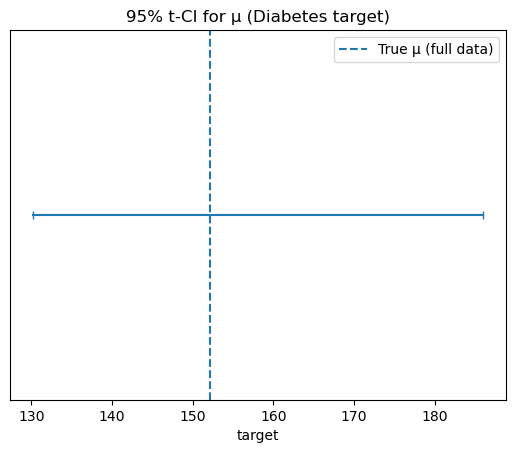

In [8]:
plt.figure()
plt.axvline(true_mu, linestyle="--", label="True μ (full data)")
plt.plot([lo, hi], [0, 0], marker="|")
plt.yticks([])
plt.xlabel("target")
plt.title("95% t-CI for μ (Diabetes target)")
plt.legend()
plt.show()


! 신뢰구간은 빈도 주의적으로 해석하여야 함

"이번 구간이 μ를 95% 확률로 포함한다”가 아니라, 이 절차로 반복해 만든 구간들 중 약 95%가 μ를 포함한다는 뜻

In [9]:
## 2) Coverage experiment (resampling from the real dataset)

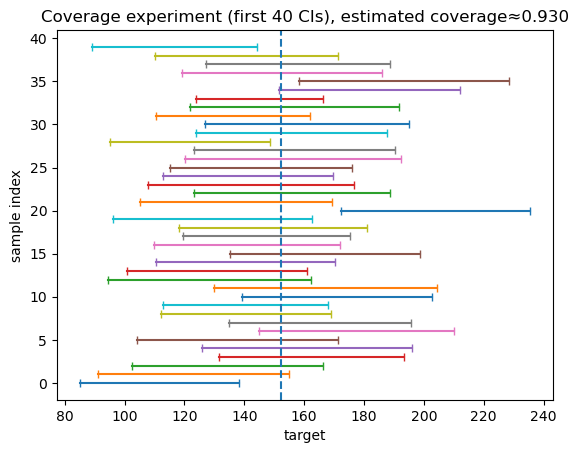

In [4]:
def coverage_experiment(series, n=25, reps=400, alpha=0.05, seed=7):
    # n = 표본 크기(개수)
    # reps = 실험을 몇번 반복할지?
    # alpha = 유의수준 (0.5면 95% 신뢰구간)
    rng = np.random.default_rng(seed) # PCG64 라는 알고리즘을 쓰는 난수 생성기, 최근 더 안정적이고 빠르다고 인정받는 최신 알고리즘
    mu_true = series.mean()
    intervals = []
    hits = 0
    for i in range(reps):
        idx = rng.integers(0, len(series), size=n)
        smp = series.to_numpy()[idx]
        lo, hi, *_ = ci_for_mean_t(smp, alpha=alpha)
        intervals.append((lo, hi))
        hits += int(lo <= mu_true <= hi)
    return mu_true, intervals, hits / reps

mu_true, intervals, cov = coverage_experiment(df["target"], n=25, reps=400, alpha=0.05, seed=11)

plt.figure()
k = 40
for i, (lo_i, hi_i) in enumerate(intervals[:k]):
    plt.plot([lo_i, hi_i], [i, i], marker="|")
plt.axvline(mu_true, linestyle="--")
plt.title(f"Coverage experiment (first {k} CIs), estimated coverage≈{cov:.3f}")
plt.xlabel("target")
plt.ylabel("sample index")
plt.show()

In [12]:
mu_true

152.13348416289594

In [14]:
cov

0.93

In [15]:
## 3) Effect of sample size on CI width (√n law)

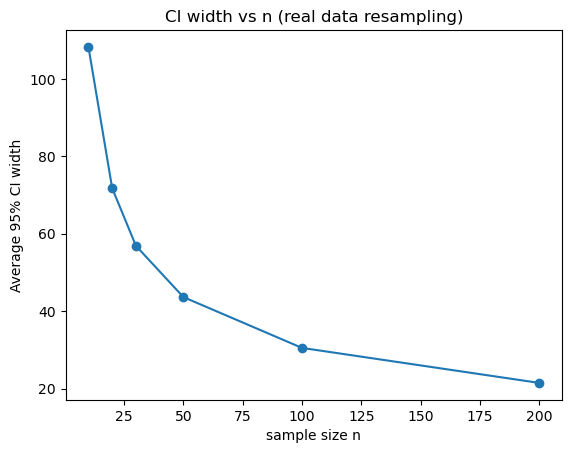

In [16]:
def avg_ci_width_vs_n(series, ns=(10, 20, 30, 50, 100, 200), reps=300, seed=2024):
    rng = np.random.default_rng(seed)
    widths = []
    for n in ns:
        ws = []
        for _ in range(reps):
            idx = rng.integers(0, len(series), size=n) # 0부터 len(series)-1까지 정수 중에서 n개를 복원 추출 -> 즉 series에서 n개의 임의 표본을 뽑음
            smp = series.to_numpy()[idx]
            lo, hi, *_ = ci_for_mean_t(smp)
            ws.append(hi - lo)
        widths.append(np.mean(ws))
    return np.array(ns), np.array(widths)

ns, widths = avg_ci_width_vs_n(df["target"], ns=(10, 20, 30, 50, 100, 200), reps=200)

plt.figure()
plt.plot(ns, widths, marker="o")
plt.xlabel("sample size n")
plt.ylabel("Average 95% CI width")
plt.title("CI width vs n (real data resampling)")
plt.show()

In [17]:
## 4) Prediction Interval (PI) vs Confidence Interval (CI) on real data

PI란 예언구간이라고도 할 수 있는데 새로운 관측값 하나가 들어올 범위

(ex. 다음 1명의 값이 어디에서 나올까? 다음 1건의 값이 어디에서 나올까?)


평균 효과/평균 매출/평균 점수 같은 집단 평균을 말할 땐 → CI

다음 달 매출 한 번, 다음 환자 한 명의 수치 등 개별 사건을 말할 땐 → PI

In [18]:
def ci_pi_from_sample(sample, alpha=0.05):
    n = len(sample)
    xbar = np.mean(sample)
    s = np.std(sample, ddof=1)
    tcrit = st.t.ppf(1 - alpha/2, df=n-1)
    ci = (xbar - tcrit * s/np.sqrt(n), xbar + tcrit * s/np.sqrt(n))
    pi = (xbar - tcrit * s*np.sqrt(1 + 1/n), xbar + tcrit * s*np.sqrt(1 + 1/n))
    return xbar, s, tcrit, ci, pi

n = 40
smp = df["target"].sample(n=n, replace=True, random_state=123).to_numpy()
xbar, s, tcrit, ci, pi = ci_pi_from_sample(smp)

cmp_df = pd.DataFrame({
    "type": ["95% CI for μ", "95% Prediction Interval for new Y"],
    "Lower": [ci[0], pi[0]],
    "Upper": [ci[1], pi[1]],
    "Width": [ci[1]-ci[0], pi[1]-pi[0]]
})

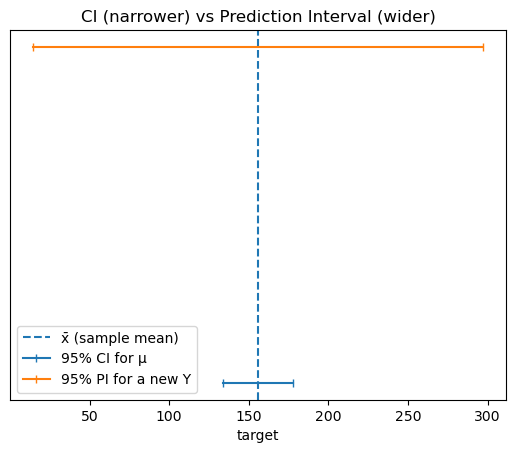

In [19]:
plt.figure()
plt.axvline(xbar, linestyle="--", label="x̄ (sample mean)")
plt.plot([ci[0], ci[1]], [0, 0], marker="|", label="95% CI for μ")
plt.plot([pi[0], pi[1]], [0.5, 0.5], marker="|", label="95% PI for a new Y")
plt.yticks([])
plt.xlabel("target")
plt.title("CI (narrower) vs Prediction Interval (wider)")
plt.legend()
plt.show()

PI는 개별값 예측이라 정규 가정이 더 민감. 분포가 심하게 비정규/헤비테일이면 폭이나 커버리지가 달라질 수 있음.

회귀 문제에서는 회귀용 PI/CI 공식이 따로 있음


In [20]:
## 5) t vs z CI on real data (illustration)


t기반 CI랑 z기반 CI랑 비교해보기

In [29]:
sigma_pop = df["target"].std(ddof=0)  # pretend this is known
n = 15
smp = df["target"].sample(n=n, replace=True, random_state=77).to_numpy()
xbar = smp.mean()
s = smp.std(ddof=1)

# z-based (pretend σ known)
z = st.norm.ppf(0.975)
ci_z = (xbar - z * sigma_pop/np.sqrt(n), xbar + z * sigma_pop/np.sqrt(n))

# t-based (σ unknown)
tcrit = st.t.ppf(0.975, df=n-1)
ci_t = (xbar - tcrit * s/np.sqrt(n), xbar + tcrit * s/np.sqrt(n))

tz_df = pd.DataFrame({
    "Interval type": ["z-based (pretend σ known)", "t-based (σ unknown)"],
    "Lower": [ci_z[0], ci_t[0]],
    "Upper": [ci_z[1], ci_t[1]],
    "Width": [ci_z[1]-ci_z[0], ci_t[1]-ci_t[0]]
})

In [30]:
tz_df

,Interval type,Lower,Upper,Width
0,z-based (pretend σ known),138.230432,216.169568,77.939136
1,t-based (σ unknown),128.692855,225.707145,97.014289
